In [1]:
import scipy as sp
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.cycleGAN import *

In [2]:
import tensorflow as tf
tf.__version__

'1.4.1'

In [3]:
# some constants

LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002
BETA1 = 0.5
BATCH_SIZE = 1
EPOCHS = 100
SAVE_SAMPLE_PERIOD = 100
task='TRAIN'
#task='TEST'
SEED=1

PATH = 'cycleGAN_test'

In [4]:
ngf=8
ndf=8
f=7
s=3

In [8]:
trunc_normal= tf.truncated_normal_initializer(stddev=0.02)
normal = tf.random_normal_initializer(stddev=0.02)

uniform = tf.random_uniform_initializer()
glorot_uniform = tf.glorot_uniform_initializer()
glorot_normal = tf.glorot_normal_initializer()

global d_sizes, g_sizes

d_sizes = {
         'conv_layers': [(ndf, f,2, False, 1, lrelu, trunc_normal),
                         (ndf*2, f, 2, True, 1, lrelu, trunc_normal),
                         (ndf*4, f, 2, True, 1, lrelu, trunc_normal)],
                         #(ndf*4, f, 1, True, 1, lrelu, trunc_normal)],
         'dense_layers': [(1024, True, 1, lrelu ,trunc_normal)],
         'readout_layer_w_init':trunc_normal,
}


g_sizes ={
         'conv_layer_0':[(ngf, f, 1, False, 1, lrelu, trunc_normal)],
         'conv_layer_1':[(ngf*2, f, 2, True, 1, lrelu, trunc_normal)],
         'conv_layer_2':[(ngf*4, 3, 2, True, 1, lrelu, trunc_normal)],
    
         'convblock_layer_0':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_0':[(ngf*4, 1, 1, True, 1, trunc_normal)],
    
         'convblock_layer_1':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_1':[(ngf*4, 1, 1, True, 1, trunc_normal)],
    
         'convblock_layer_2':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_2':[(ngf*4, 1, 1, True, 1, trunc_normal)],
    
         'convblock_layer_3':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_3':[(ngf*4, 1, 1, True, 1, trunc_normal)],
    
         'convblock_layer_4':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_4':[(ngf*4, 1, 1, True, 1, trunc_normal)],
         
         'convblock_layer_5':[(ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal),
                                (ngf*4, 3, 1, True, 1, lrelu, trunc_normal)],
         'convblock_shortcut_layer_5':[(ngf*4, 1, 1, True, 1, trunc_normal)],

    
         #'deconv_layer_0':[(ngf*2, 3, 2, False, 1, lrelu, trunc_normal)],
         #'deconv_layer_1':[(ngf, f, 2, True, 1, lrelu, trunc_normal)],
         'deconv_layer_0':[(3, f, 2, False, 1, tf.nn.tanh, trunc_normal)],
         
        
}


In [9]:
def Horse2Zebra():
    
    train_A = np.array(
        [plt.imread("apple2orange/trainA/"+filename) for filename in os.listdir("apple2orange/trainA")]
    )
    
    train_B = np.array(
        [plt.imread("apple2orange/trainB/"+filename) for filename in os.listdir("apple2orange/trainB")]
    )
    
    m = np.minimum(train_A.shape[0],train_B.shape[0])
    
    _, n_H, n_W, n_C = train_A.shape
    
    X_train_A = train_A[0:m]
    X_train_B = train_B[0:m]
    
    train_A=train_A.astype(np.float32)
    mean_A=np.mean(train_A,axis=0)
    train_A-=mean_A
    std_A=np.std(train_A,axis=0)
    train_A/=std_A
    
    train_B=train_B.astype(np.float32)
    mean_B=np.mean(train_B,axis=0)
    train_B-=mean_B
    std_B=np.std(train_B,axis=0)
    train_B/=std_B
    
    tf.reset_default_graph()

    gan = cycleGAN(n_H, n_W, n_C, mean_A, std_A, mean_B, std_B, d_sizes, d_sizes, g_sizes, g_sizes,
                   lr_g=LEARNING_RATE_G, lr_d=LEARNING_RATE_D,beta1=BETA1,
                  batch_size=BATCH_SIZE, epochs=EPOCHS,
                  save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(train_A, train_B)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        done = True
        while not done:
            
            
            j = np.random.choice(len(X_train_A))
            true_img = X_train_A[j]
            sample_img = gan.get_sample(true_img)
            
            plt.subplot(1,2,1)
            plt.imshow(true_img.reshape(n_H,n_W),cmap='gray')
            plt.subplot(1,2,2)
            plt.imshow(sample_img.reshape(n_H,n_W),cmap='gray')
            
            fig=plt.gcf()
            fig.set_size_inches(5,8)
            plt.savefig(PATH+'/sample_{0}_at_iter_{1}.png'.format(j, total_iters),dpi=300)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Convolutional Network architecture detected
Convolutional Network architecture detected
Discriminator_A
Input for convolution shape  (?, 256, 256, 3)
Logits shape (?, 1)
Generator_A_to_B
Input for generator shape (?, 256, 256, 3)
Generator output shape (?, 256, 256, 3)
Discriminator_B
Input for convolution shape  (?, 256, 256, 3)
Logits shape (?, 1)
Generator_B_to_A
Input for generator shape (?, 256, 256, 3)
Generator output shape (?, 256, 256, 3)
Discriminator_A
Input for convolution shape  (?, 256, 256, 3)
Logits shape (?, 1)
Discriminator_B
Input for convolution shape  (?, 256, 256, 3)
Logits shape (?, 1)
Generator_A_to_B
Input for generator shape (?, 256, 256, 3)
Generator output shape (?, 256, 256, 3)
Generator_B_to_A
Input for generator shape (?, 256, 256, 3)
Generator output shape (?, 256, 256, 3)
Generator_A_to_B
Input for generator shape (?, 256, 256, 3)
Generator output shape (?, 256, 256, 3)
Generator_B_to_A
Input for generator shape (?, 256, 256, 3)
Generator output shape (

/home/ttp/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


At iter: 300  -  dt: 0:00:00.161455 - d_acc_A: 0.50
At iter: 300  -  dt: 0:00:00.162505 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 10.63
Discrimator_B cost 0.5, Generator_B_to_A cost 10.51
Saving a sample...
At iter: 400  -  dt: 0:00:00.159778 - d_acc_A: 0.50
At iter: 400  -  dt: 0:00:00.160443 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 9.372
Discrimator_B cost 0.5, Generator_B_to_A cost 9.105
Saving a sample...
At iter: 500  -  dt: 0:00:00.161654 - d_acc_A: 0.50
At iter: 500  -  dt: 0:00:00.162753 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 9.957
Discrimator_B cost 0.5001, Generator_B_to_A cost 9.749
Saving a sample...
At iter: 600  -  dt: 0:00:00.163068 - d_acc_A: 0.50
At iter: 600  -  dt: 0:00:00.163265 - d_acc_B: 0.50
Discrimator_A cost 0.5001, Generator_A_to_B cost 9.031
Discrimator_B cost 0.5001, Generator_B_to_A cost 8.32
Saving a sample...
At iter: 700  -  dt: 0:00:00.159929 - d_acc_A: 0.50
At iter: 700  -  dt: 0:00:00.160

At iter: 3900  -  dt: 0:00:00.160734 - d_acc_A: 0.50
At iter: 3900  -  dt: 0:00:00.160951 - d_acc_B: 0.50
Discrimator_A cost 0.4999, Generator_A_to_B cost 8.839
Discrimator_B cost 0.5, Generator_B_to_A cost 8.826
Saving a sample...
Epoch: 4
At iter: 4000  -  dt: 0:00:00.162220 - d_acc_A: 0.50
At iter: 4000  -  dt: 0:00:00.162307 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 7.244
Discrimator_B cost 0.5, Generator_B_to_A cost 7.008
Saving a sample...
At iter: 4100  -  dt: 0:00:00.163718 - d_acc_A: 0.50
At iter: 4100  -  dt: 0:00:00.163833 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 6.566
Discrimator_B cost 0.5, Generator_B_to_A cost 6.396
Saving a sample...
At iter: 4200  -  dt: 0:00:00.162164 - d_acc_A: 0.50
At iter: 4200  -  dt: 0:00:00.162373 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 6.002
Discrimator_B cost 0.5, Generator_B_to_A cost 5.934
Saving a sample...
At iter: 4300  -  dt: 0:00:00.163474 - d_acc_A: 0.50
At iter: 4300  -  d

At iter: 7500  -  dt: 0:00:00.160506 - d_acc_A: 0.50
At iter: 7500  -  dt: 0:00:00.160738 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 8.032
Discrimator_B cost 0.5, Generator_B_to_A cost 7.93
Saving a sample...
At iter: 7600  -  dt: 0:00:00.161618 - d_acc_A: 0.50
At iter: 7600  -  dt: 0:00:00.161836 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 4.922
Discrimator_B cost 0.5, Generator_B_to_A cost 4.555
Saving a sample...
At iter: 7700  -  dt: 0:00:00.161506 - d_acc_A: 0.50
At iter: 7700  -  dt: 0:00:00.161718 - d_acc_B: 0.50
Discrimator_A cost 0.5001, Generator_A_to_B cost 6.242
Discrimator_B cost 0.5, Generator_B_to_A cost 6.099
Saving a sample...
At iter: 7800  -  dt: 0:00:00.159400 - d_acc_A: 0.50
At iter: 7800  -  dt: 0:00:00.159614 - d_acc_B: 0.50
Discrimator_A cost 0.5, Generator_A_to_B cost 8.414
Discrimator_B cost 0.5, Generator_B_to_A cost 7.749
Saving a sample...
At iter: 7900  -  dt: 0:00:00.160274 - d_acc_A: 0.50
At iter: 7900  -  dt: 0:00:00

KeyboardInterrupt: 

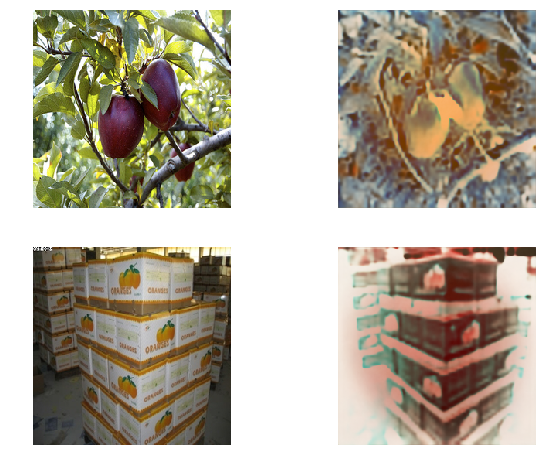

In [10]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        Horse2Zebra()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            Horse2Zebra()